In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from scipy.linalg import eigh
from scipy.stats import multivariate_normal as gaussian
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.datasets import load_wine
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path
import plda
from copy import deepcopy

## Data

In [91]:
#wine data for showing how to train plda
wine = load_wine()
seed=1
training_data, testing_data, training_labels, testing_labels=train_test_split(wine.data, 
                                                                              wine.target, 
                                                                              test_size=0.2, 
                                                                              random_state=seed)

In [92]:
wine.data.shape, wine.target.shape

((178, 13), (178,))

In [93]:
training_data.shape, training_labels.shape

((142, 13), (142,))

In [94]:
testing_data.shape, testing_labels.shape

((36, 13), (36,))

## Helpers

source: https://github.com/RaviSoji/plda

In [95]:
def calc_scatter_matrices(X, Y):
    """ See Equations (1) on p.532 of Ioffe 2006. """
    assert len(X.shape) == 2
    assert X.shape[0] == len(Y)

    unique_labels = np.unique(Y)
    labels = np.asarray(Y)

    m = X.mean(axis=0)
    N = X.shape[0]

    cov_ks = []
    m_ks = []
    n_ks = []

    for k in unique_labels:
        bool_idxs = labels == k
        X_k = X[bool_idxs]

        m_ks.append(X_k.mean(axis=0))
        n_ks.append(bool_idxs.sum())

        cov_ks.append(np.cov(X_k.T))

    n_ks = np.asarray(n_ks)
    m_ks = np.asarray(m_ks)
    m_ks_minus_m = m_ks - m
    S_b = np.matmul(m_ks_minus_m.T * (n_ks / N), m_ks_minus_m)

    S_w = np.asarray(cov_ks) * ((n_ks - 1) / N)[:, None, None]
    S_w = np.sum(S_w, axis=0)

    return S_b, S_w


In [96]:
def calc_m(X):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    assert len(X.shape) == 2
    return X.mean(axis=0)

def calc_W(S_b, S_w):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    eigenvalues, eigenvectors = eigh(S_b, S_w)
    return eigenvectors

def calc_Lambda_b(S_b, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    return np.matmul(np.matmul(W.T, S_b), W)

def calc_Lambda_b(S_b, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    return (W.T@ S_b)@ W

def calc_Lambda_w(S_w, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    return np.matmul(np.matmul(W.T, S_w), W)

def calc_Lambda_w(S_w, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    return (W.T@ S_w)@ W

def calc_n_avg(Y):
    """ This is the \"hack\" suggested in Fig 2 on p.537 of Ioffe 2006. """
    unique = np.unique(Y)
    return len(Y) / unique.shape[0]

def calc_A(n_avg, Lambda_w, W):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    Lambda_w_diagonal = Lambda_w.diagonal()  # Should be diagonal matrix.
    inv_W_T = np.linalg.inv(W.T)
    return inv_W_T * (n_avg / (n_avg - 1) * Lambda_w_diagonal) ** .5


def calc_Psi(Lambda_w, Lambda_b, n_avg):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    Lambda_w_diagonal = Lambda_w.diagonal()  # Should be diagonal matrix.
    Lambda_b_diagonal = Lambda_b.diagonal()  # Should be diagonal matrix.
    Psi = (n_avg - 1) / n_avg * Lambda_b_diagonal / Lambda_w_diagonal
    Psi -= 1 / n_avg
    Psi[Psi <= 0] = 0

    return np.diag(Psi)

def get_relevant_U_dims(Psi):
    """ See Fig. 2 on p.537 of Ioffe 2006. """
    relevant_dims = np.squeeze(np.argwhere(Psi.diagonal() != 0))
    if relevant_dims.shape == ():
        relevant_dims = relevant_dims.reshape(1,)
    return relevant_dims

def optimize_maximum_likelihood(X, labels):
    """ Performs the optimization in Fig. 2 of p.537 of Ioffe 2006.

    DESCRIPTION
     - The main model parameters are `m`, `A`, and `Psi`.
     - However, to improve the performance (speed and numerical stability)
        of the plda.Model object,
        inv_A and relevant_U_dims are also returned here.

    ADDITIONAL NOTES
     Be sure to test that np.cov(X.T) is full rank before running this.

     Recall that there are 4 \"spaces\":
      'D' (data) <---> 'X' (preprocessed) <---> 'U' (latent) <---> 'U_model'

    ARGUMENTS
     X  (numpy.ndarray), shape=(n_data, n_dimensions)
       - Data in statistics format, i.e. row-wise.

     labels  (list or numpy.ndarray), length=X.shape[0]
       - Labels for the data in `X`.
       - Must be sorted in the same order as `X`.

    RETURNS
     m  (numpy.ndarray), shape=X.shape[-1]
       - The mean of the row vectors in X.
       - This is the prior mean fitted via maximum likelihood.

     A  (numpy.ndarray), shape=(X.shape[-1], X.shape[-1])
       - Transformation from X space to the latent U space.

     Psi  (numpy.ndarray), shape=(X.shape[-1], X.shape[-1])
       - The covariance matrix of the prior distribution on
          the category means in U space.

     relevant_U_dims  (numpy.ndarray), shape=(len(np.unique(labels)) - 1,)
       - The \"effective\" latent dimensions,
          i.e. the ones that are actually used by the model.

     inv_A  (numpy.ndarray), shape=A.shape
       - The inverse of the matrix A.
       - Transformation from the latent U space to the X space.
    """
    assert len(X.shape) == 2
    assert X.shape[0] == len(labels)

    m = X.mean(axis=0)

    S_b, S_w = calc_scatter_matrices(X, labels)
    W = calc_W(S_b, S_w)

    Lambda_b = calc_Lambda_b(S_b, W)
    Lambda_w = calc_Lambda_w(S_w, W)
    n_avg = calc_n_avg(labels)

    A = calc_A(n_avg, Lambda_w, W)
    inv_A = np.linalg.inv(A)

    Psi = calc_Psi(Lambda_w, Lambda_b, n_avg)
    relevant_U_dims = get_relevant_U_dims(Psi)

    return m, A, Psi, relevant_U_dims, inv_A



## Example training

In [97]:
data=training_data
labels=training_labels
n_principal_components=3

In [98]:
data.shape

(142, 13)

In [99]:
len(labels)

142

#### Scatte matrices (not needed if n_principal components set)

In [100]:
S_b, S_w = calc_scatter_matrices(data, labels)
matrix_rank = np.linalg.matrix_rank(S_w)

In [101]:
S_b[0]

array([ 3.63313630e-01,  8.44582469e-02,  6.01357766e-02, -6.42932054e-01,
        3.28876707e+00,  1.02619637e-01,  1.41543839e-01, -1.17745873e-02,
        3.79299602e-02,  7.56522136e-01, -1.93957965e-02,  3.88631078e-02,
        1.38336210e+02])

In [102]:
matrix_rank

13

well set it to n_components not to overlearn

In [103]:
matrix_rank=n_principal_components

#### PCA

In [104]:
pca = PCA(n_components=matrix_rank)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### transform

In [105]:
X=pca.transform(data)

In [106]:
X.shape

(142, 3)

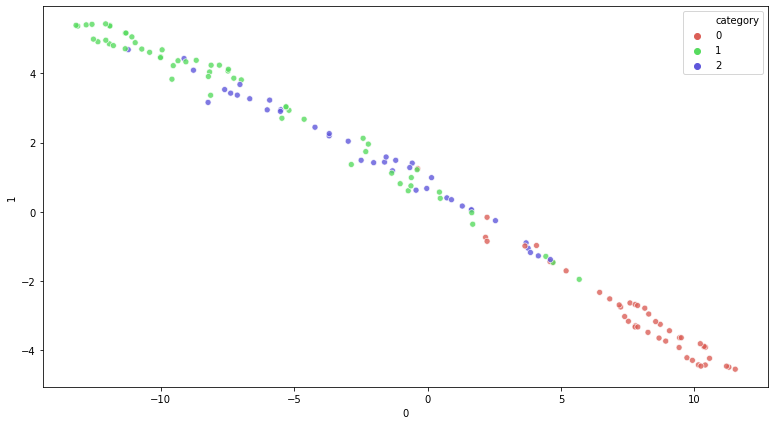

In [107]:
#plot transformed features
#use tsne to get 2 dim
X_tsne = TSNE(n_components=2).fit_transform(X)

df_tsne = pd.DataFrame(X_tsne)
df_tsne.columns = [str(c) for c in df_tsne.columns]
df_tsne['category'] = training_labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x="0", y="1",
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 3),
    data=df_tsne,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

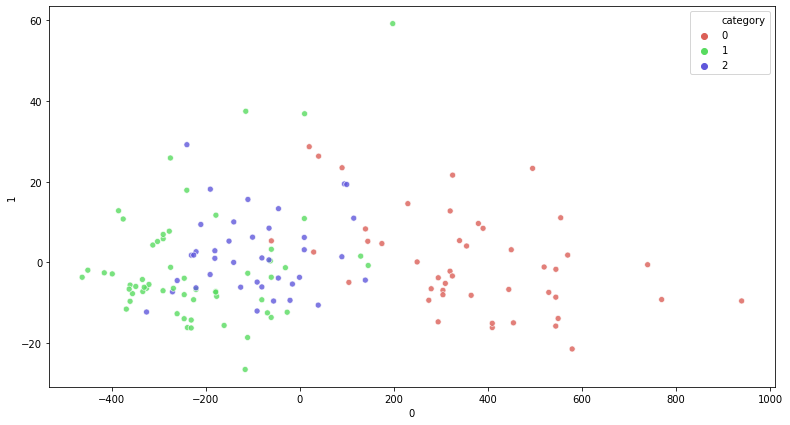

In [108]:
#plot pca features, if only 2-dim
pca_2dim = PCA(n_components=2)
pca_2dim.fit(data)
X_2dim=pca_2dim.transform(data)
df_x2dim=pd.DataFrame(X_2dim)
df_x2dim['category']=labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x=0, y=1,
    hue="category",
        palette=sns.color_palette("hls", 3),
    data=df_x2dim,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

#### learn params

In [109]:
m, A, Psi, relevant_U_dims, inv_A = optimize_maximum_likelihood(X, labels)

In [110]:
m

array([2.56195691e-14, 5.69184762e-15, 5.20983882e-15])

In [111]:
A

array([[ 1.84489059e+01, -4.42685021e+01, -1.54801490e+02],
       [-1.23141262e+01, -2.61292942e+00, -1.36302888e-01],
       [-7.08717991e-01,  2.63048726e+00, -2.85885986e-01]])

In [112]:
Psi

array([[0.        , 0.        , 0.        ],
       [0.        , 0.2633962 , 0.        ],
       [0.        , 0.        , 2.61352107]])

In [113]:
relevant_U_dims

array([1, 2], dtype=int64)

In [114]:
inv_A

array([[ 2.02000042e-04, -7.67148457e-02, -7.28033323e-02],
       [-6.25588536e-04, -2.10095431e-02,  3.48760358e-01],
       [-6.25691299e-03, -3.13462078e-03, -1.08411363e-01]])

#### transfrom X from space X to U_model (orig to latent space with corrent number of dimensions)

In [115]:
relevant_U_dims

array([1, 2], dtype=int64)

In [116]:
#from X -> U
x_in_u=np.matmul(X - m, inv_A.T)

U_model=x_in_u[..., relevant_U_dims]
U_model.round(3)[0]

array([0.035, 1.936])

In [117]:
x_in_u=(X - m)@ inv_A.T
U_model=x_in_u[..., relevant_U_dims]
U_model.round(3)[0], U_model.shape

(array([0.035, 1.936]), (142, 2))

In [118]:
np.allclose(x_in_u[..., relevant_U_dims], x_in_u[:, relevant_U_dims])

True

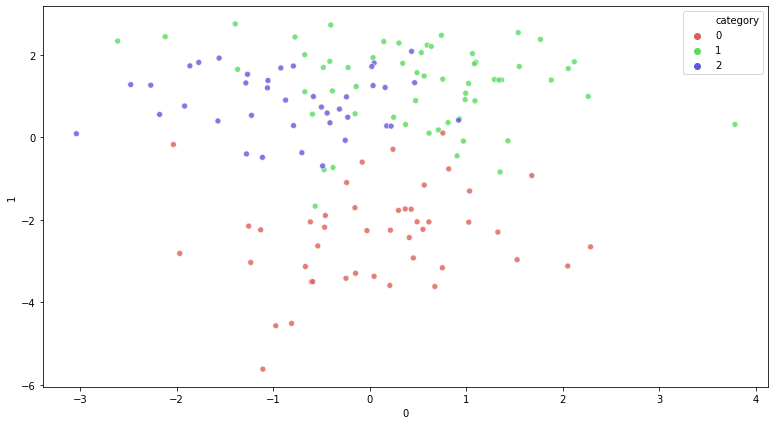

In [119]:
#U_dim
df_udim_model=pd.DataFrame(U_model)
df_udim_model['category']=labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x=0, y=1,
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 3),
    data=df_udim_model,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

## Learn some params for inference

#### get prior params

In [120]:
cov_diag = Psi.diagonal()[relevant_U_dims]
mean = np.zeros(relevant_U_dims.shape)

prior_params= {'mean': mean, 'cov_diag': cov_diag}
mean

array([0., 0.])

In [33]:
cov_diag

array([0.2633962 , 2.61352107])

In [34]:
Psi.diagonal()

array([0.        , 0.2633962 , 2.61352107])

#### get posterior params

In [45]:
labels = np.asarray(labels)
prior_cov_diagonal = prior_params['cov_diag']

cov_diags = []
means = []
categories = []

for k in np.unique(labels):
#     print(k)
    bool_idxs = labels == k
    U_model_k = U_model[bool_idxs]
    n_k = bool_idxs.sum()

    cov_diag = prior_cov_diagonal / (1 + n_k * prior_cov_diagonal)
    mean = U_model_k.sum(axis=0) * cov_diag

    cov_diags.append(cov_diag)
    means.append(mean)
    categories.append(k)

    #add them to dict
posterior_params = dict()
for label, mean, cov_diag in zip(categories, means, cov_diags):
    category_params = dict()
    category_params['mean'] = mean
    category_params['cov_diag'] = cov_diag

    posterior_params[label] = category_params

In [46]:
posterior_params

{0: {'mean': array([ 0.07163113, -2.35134876]),
  'cov_diag': array([0.02049325, 0.02203486])},
 1: {'mean': array([0.46043557, 1.2515773 ]),
  'cov_diag': array([0.01618213, 0.01712838])},
 2: {'mean': array([-0.74652464,  0.85418408]),
  'cov_diag': array([0.02336636, 0.02539191])}}

#### get posterior_predictive_params

In [47]:
posterior_predictive_params = posterior_params.copy()

for k, k_params in posterior_predictive_params.items():
    k_params['cov_diag'] += 1

In [48]:
posterior_predictive_params

{0: {'mean': array([ 0.07163113, -2.35134876]),
  'cov_diag': array([1.02049325, 1.02203486])},
 1: {'mean': array([0.46043557, 1.2515773 ]),
  'cov_diag': array([1.01618213, 1.01712838])},
 2: {'mean': array([-0.74652464,  0.85418408]),
  'cov_diag': array([1.02336636, 1.02539191])}}

#### as one chunk for medium post

In [49]:
prior_cov_diagonal=cov_diag = Psi.diagonal()[relevant_U_dims]
mean = np.zeros(relevant_U_dims.shape)

labels = np.asarray(labels)
cov_diags = []
means = []
categories = []

for k in np.unique(labels):
    bool_idxs = labels == k
    U_model_k = U_model[bool_idxs]
    n_k = bool_idxs.sum()
    #calculate psi/(1+n*psi)
    cov_diag = prior_cov_diagonal / (1 + n_k * prior_cov_diagonal)
    mean = U_model_k.sum(axis=0) * cov_diag

    cov_diags.append(cov_diag+1)
    means.append(mean)
    categories.append(k)

In [50]:
cov_diags

[array([1.02049325, 1.02203486]),
 array([1.01618213, 1.01712838]),
 array([1.02336636, 1.02539191])]

In [51]:
posterior_params

{0: {'mean': array([ 0.07163113, -2.35134876]),
  'cov_diag': array([1.02049325, 1.02203486])},
 1: {'mean': array([0.46043557, 1.2515773 ]),
  'cov_diag': array([1.01618213, 1.01712838])},
 2: {'mean': array([-0.74652464,  0.85418408]),
  'cov_diag': array([1.02336636, 1.02539191])}}

## Predict on new data (inference)

#### transform from D to U_model

In [52]:
data_temp=pca.transform(testing_data)
data_temp=np.matmul(data_temp - m, inv_A.T)
testing_data_transformed=data_temp[..., relevant_U_dims]

In [53]:
testing_data_transformed.shape

(36, 2)

In [54]:
testing_data_transformed[0]

array([-0.34463147,  0.4083779 ])

In [55]:
testing_data_transformed[1]

array([0.01796129, 2.38279116])

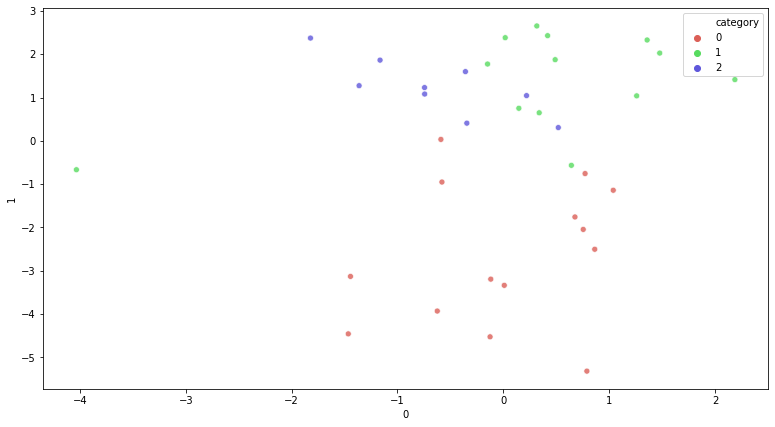

In [56]:
#testing_data_transformed
df_testing_data_transformed=pd.DataFrame(testing_data_transformed)
df_testing_data_transformed['category']=testing_labels

plt.figure(figsize=(13, 7))
ax = sns.scatterplot(
    x=0, y=1,
    hue="category",
#     palette=['green', 'orange'],
        palette=sns.color_palette("hls", 3),
    data=df_testing_data_transformed,
    legend="full",
    alpha=0.8
)
plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
plt.show()

#### calculate logprobs per category

In [57]:
def calc_logp_posterior_predictive( U_model, category):
    mean = posterior_predictive_params[category]['mean']
    cov_diag = posterior_predictive_params[category]['cov_diag']

    return gaussian(mean, np.diag(cov_diag)).logpdf(U_model)

In [58]:
logpps_by_category = []
K =  [k for k in posterior_params.keys()]

for k in K:
    logpps_k = calc_logp_posterior_predictive(testing_data_transformed, k)
    logpps_by_category.append(logpps_k)

logpps_by_category = np.stack(logpps_by_category, axis=-1)

logps = logpps_by_category
K=np.asarray(K)

In [59]:
K[np.argmax(logps, axis=-1)]

array([2, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       1, 2, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 1, 1])

In [60]:
logps[1]

array([-12.82476965,  -2.57977574,  -3.286899  ])

In [61]:
len(logps)

36

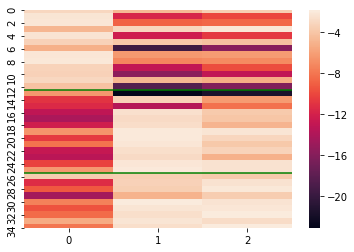

In [62]:
#sorted by the labels
sorted_test_labels=np.sort(testing_labels)
sort_idx=np.argsort(testing_labels)
ax=sns.heatmap(logps[sort_idx,])
ax.hlines(np.where(sorted_test_labels[:-1] != sorted_test_labels[1:])[0], *ax.get_xlim(), color='green')

#### get highest logprob

In [63]:
predictions = K[np.argmax(logps, axis=-1)]

In [64]:
predictions

array([2, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       1, 2, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 1, 1])

In [65]:
print(classification_report(testing_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.86      0.92      0.89        13
           2       0.78      0.78      0.78         9

    accuracy                           0.89        36
   macro avg       0.88      0.88      0.88        36
weighted avg       0.89      0.89      0.89        36



## Classification lda, pca, plda

In [52]:
#helper for plotting
def plot_tsne(x, y, n_components=2):
    X_tsne = TSNE(n_components=2).fit_transform(x)

    df_tsne = pd.DataFrame(X_tsne)
    df_tsne.columns = [str(c) for c in df_tsne.columns]
    df_tsne['category'] = y

    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        x="0", y="1",
        hue="category",
#         palette=['green', 'orange'],
        palette=sns.color_palette("hls", 3),
        data=df_tsne,
        legend="full",
        alpha=0.7
    )
    plt.setp(ax.get_legend().get_texts(), fontsize='22')  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='25')  # for legend title

In [58]:
f1=[]
f1_pca=[]
f1_lda=[]
f1_plda=[]
for seed in range(50):
    #without lda
    X_train, X_test, y_train, y_test=train_test_split(wine.data, wine.target, test_size=0.3, random_state=seed)
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

    pipe.fit(X_train, y_train)
    pred=pipe.predict(X_test)
    f1.append((f1_score(y_test, pred, average='micro')))
    
    #with pca
    pipe_pca = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])
    pca=PCA(n_components=2)
    X_train_pca=pca.fit_transform(X_train, y_train)
    X_test_pca=pca.transform(X_test)
    pipe_pca.fit(X_train_pca, y_train)
    pred_pca=pipe_pca.predict(X_test_pca)
    f1_pca.append(f1_score(y_test, pred_pca, average='micro'))
    
    #with lda
    pipe_lda = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

    lda=LinearDiscriminantAnalysis()
    X_train_lda=lda.fit_transform(X_train, y_train)
    X_test_lda=lda.transform(X_test)

    pipe_lda.fit(X_train_lda, y_train)
    pred_lda=pipe_lda.predict(X_test_lda)
    f1_lda.append(f1_score(y_test, pred_lda, average='micro'))
    
    #with plda
    better_classifier = plda.Classifier()
    better_classifier.fit_model(X_train, y_train, n_principal_components=13)
    pred_plda, log_p_predictions = better_classifier.predict(X_test)
    f1_plda.append(f1_score(y_test, pred_plda, average='micro'))

In [59]:
print(np.mean(f1))

0.9777777777777777


In [60]:
print(np.mean(f1_pca))

0.6603703703703704


In [62]:
print(np.mean(f1_lda))

0.9848148148148148


In [63]:
print(np.mean(f1_plda))

0.9825925925925927


## Classifiy mnist data

In [11]:
training_data = np.load('mnist_demo/mnist_data/mnist_train_images.npy')
training_labels = np.load('mnist_demo/mnist_data/mnist_train_labels.npy')

testing_data = np.load('mnist_demo/mnist_data/mnist_test_images.npy')
testing_labels = np.load('mnist_demo/mnist_data/mnist_test_labels.npy')

In [12]:
training_data.shape, testing_data.shape

((200, 784), (100, 784))

In [13]:
data_all=np.append(training_data, testing_data, axis=0)
all_labels=np.append(training_labels, testing_labels)
data_all.shape, all_labels.shape

((300, 784), (300,))

In [67]:
f1s=[]
f1_pcas=[]
f1_ldas=[]
f1_pldas=[]
f1_lda_pldas=[]
n_comps=[]
seeds=[]
for n_components in range(10, 100, 10):
    for seed in range(50):
        #without lda
        X_train, X_test, y_train, y_test=train_test_split(data_all, all_labels, test_size=0.3, random_state=seed)
        pipe = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

        pipe.fit(X_train, y_train)
        pred=pipe.predict(X_test)
        f1s.append((f1_score(y_test, pred, average='micro')))

        #with pca
        pipe_pca = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])
        pca=PCA(n_components=n_components)
        X_train_pca=pca.fit_transform(X_train, y_train)
        X_test_pca=pca.transform(X_test)
        pipe_pca.fit(X_train_pca, y_train)
        pred_pca=pipe_pca.predict(X_test_pca)
        f1_pcas.append(f1_score(y_test, pred_pca, average='micro'))

        #with lda
        pipe_lda = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

        lda=LinearDiscriminantAnalysis(n_components=n_components)
        X_train_lda=lda.fit_transform(X_train, y_train)
        X_test_lda=lda.transform(X_test)

        pipe_lda.fit(X_train_lda, y_train)
        pred_lda=pipe_lda.predict(X_test_lda)
        f1_ldas.append(f1_score(y_test, pred_lda, average='micro'))

        #with plda
        better_classifier = plda.Classifier()
        better_classifier.fit_model(X_train, y_train, n_principal_components=n_components)
        pred_plda, log_p_predictions = better_classifier.predict(X_test)
        f1_pldas.append(f1_score(y_test, pred_plda, average='micro'))
        
        #with lda+plda
        pipe_lda_plda = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])

        lda=LinearDiscriminantAnalysis(n_components=n_components)
        X_train_lda=lda.fit_transform(X_train, y_train)
        X_test_lda=lda.transform(X_test)
        
        better_classifier = plda.Classifier()
        better_classifier.fit_model(X_train_lda, y_train)
        
        pred_lda_plda, log_p_predictions = better_classifier.predict(X_test_lda)
        f1_lda_pldas.append(f1_score(y_test, pred_lda_plda, average='micro'))
        
        seeds.append(seed)
        n_comps.append(n_components)


C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Ana

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Ana

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Ana

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Ana

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Ana

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Ana

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10 - 1) = 9 components.
  ChangedBehaviorWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\risto\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(784, 10

In [68]:
df_comparison=pd.DataFrame({'n_comps':n_comps, 'seed':seeds, 'orig':f1s, 'pca':f1_pcas,
                           'lda':f1_ldas, 'plda':f1_pldas, 'lda_plda':f1_lda_pldas})

C:\Users\risto\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\boxplot.py:375: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E3F7E2E8C8>,
      dtype=object)

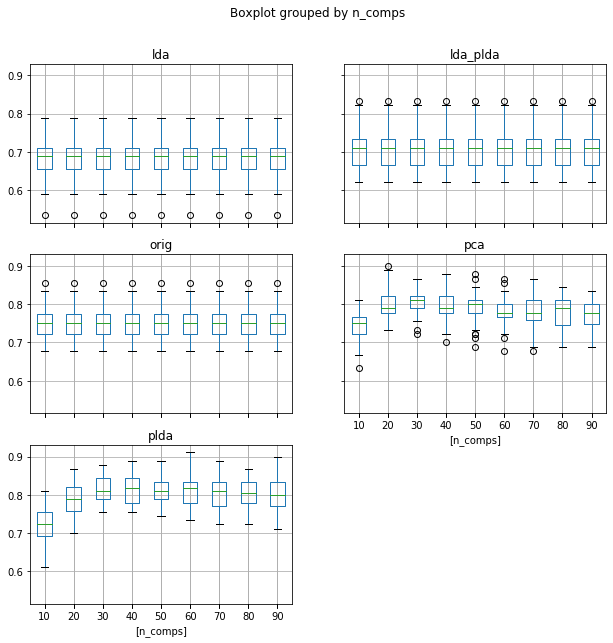

In [69]:
fig, ax =plt.subplots(figsize=(10,10))
df_comparison[['n_comps','orig','pca','lda','plda', 'lda_plda']].boxplot(by='n_comps', ax=ax)

In [70]:
df_comparison[['n_comps','orig','pca','lda','plda', 'lda_plda']].groupby('n_comps').mean()

,orig,pca,lda,plda,lda_plda
n_comps,,,,,
10,0.749778,0.743333,0.683556,0.725333,0.705556
20,0.749778,0.799556,0.683556,0.787111,0.705556
30,0.749778,0.808222,0.683556,0.813333,0.705556
40,0.749778,0.796222,0.683556,0.817333,0.705556
50,0.749778,0.791778,0.683556,0.809111,0.705556
60,0.749778,0.780000,0.683556,0.807556,0.705556
70,0.749778,0.780222,0.683556,0.802667,0.705556
80,0.749778,0.777333,0.683556,0.802444,0.705556
90,0.749778,0.772444,0.683556,0.801111,0.705556


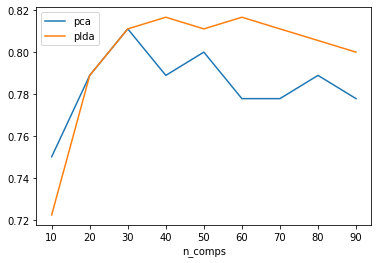

In [71]:
#pca vs plda accuracy nr of components we keep
df_comparison[['n_comps','orig','pca','lda','plda', 'lda_plda']].groupby('n_comps').median()[['pca', 'plda']].plot()

#### comparison with simple linear svc

In [26]:
#compare with simple linearsvc model 
#NB! if you play with test_size, you can see that this and follownig cell models have different results
X_train, X_test, y_train, y_test=train_test_split(data_all, all_labels, test_size=0.1, random_state=1)

svc=LinearSVC()
svc.fit(X_train, y_train)
pred_svc=svc.predict(X_test)

print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.75      1.00      0.86         3
           2       1.00      0.50      0.67         2
           3       0.80      1.00      0.89         4
           4       1.00      0.67      0.80         3
           5       0.50      1.00      0.67         1
           6       1.00      1.00      1.00         6
           7       0.80      0.80      0.80         5
           9       1.00      0.80      0.89         5

    accuracy                           0.87        30
   macro avg       0.87      0.86      0.84        30
weighted avg       0.90      0.87      0.87        30



#### comparison with simple linear svc + plda

In [25]:
#compare with simple linearsvc model +plda
better_classifier = plda.Classifier()
better_classifier.fit_model(X_train, y_train, n_principal_components=40)
plda_pred_train, log_p_predictions_train, X_train_plda = better_classifier.predict(X_train, return_data=True)

plda_pred_test, log_p_predictions_test,  X_test_plda=better_classifier.predict(X_test, return_data=True)

svc=LinearSVC()
#a bit overlearned as we use same training data for plda and svc
svc.fit(X_train_plda, y_train)
pred_svc=svc.predict(X_test_plda)

print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       0.80      1.00      0.89         4
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         6
           7       1.00      0.80      0.89         5
           9       1.00      0.80      0.89         5

    accuracy                           0.93        30
   macro avg       0.95      0.96      0.95        30
weighted avg       0.95      0.93      0.93        30



C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Clustering

In [5]:
#helpers
def plot_tsne(X, target,palette='tab10'):
    #compare original data, plotted with tsne/PCA
    X_tsne = TSNE(n_components=2).fit_transform(X)

    df_tsne = pd.DataFrame(X_tsne)
    df_tsne.columns = [str(c) for c in df_tsne.columns]
    df_tsne['category'] = target

    plt.figure(figsize=(5, 4))
    ax = sns.scatterplot(
        x="0", y="1",
        hue="category",
        palette=palette,
        data=df_tsne,
        legend="full",
        alpha=0.8
    )
    plt.setp(ax.get_legend().get_texts(), fontsize='10')  # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='10')  # for legend title
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [158]:
training_data = np.load('mnist_demo/mnist_data/mnist_train_images.npy')
training_labels = np.load('mnist_demo/mnist_data/mnist_train_labels.npy')

testing_data = np.load('mnist_demo/mnist_data/mnist_test_images.npy')
testing_labels = np.load('mnist_demo/mnist_data/mnist_test_labels.npy')

data_all=np.append(training_data, testing_data, axis=0)
all_labels=np.append(training_labels, testing_labels)
data_all.shape, all_labels.shape

((300, 784), (300,))

In [159]:
X_train, X_test, y_train, y_test=train_test_split(data_all, all_labels, test_size=0.3, random_state=seed)

#sort data for better clustering visualization
test_sort_index=y_test.argsort()
sorted_y_test=y_test[test_sort_index]
new_number_idx=np.where(sorted_y_test[:-1] != sorted_y_test[1:])[0]

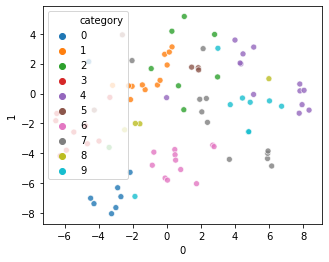

In [160]:
#tsne orig data
plot_tsne(X_test, y_test)

In [180]:
better_classifier = plda.Classifier()
better_classifier.fit_model(X_train, y_train, n_principal_components=40)
pred_plda, log_p_predictions, X_test_transformed = better_classifier.predict(X_test[test_sort_index], return_data=True)

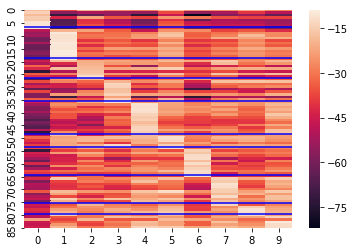

In [181]:
ax=sns.heatmap(log_p_predictions)
ax.hlines(new_number_idx, *ax.get_xlim(),color='blue')

In [182]:
#compare each sample vector other sample vectors
cossim_mat=cosine_similarity(log_p_predictions, log_p_predictions)

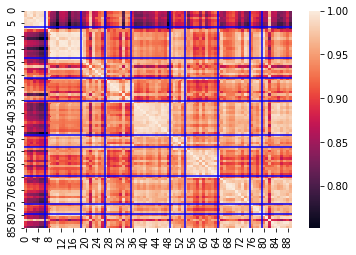

In [183]:
ax=sns.heatmap(cossim_mat)
ax.hlines(new_number_idx, *ax.get_xlim(),color='blue')
ax.vlines(new_number_idx, *ax.get_xlim(),color='blue')

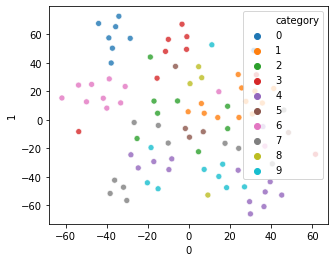

In [184]:
#tsne orig data
plot_tsne(X_test, y_test)

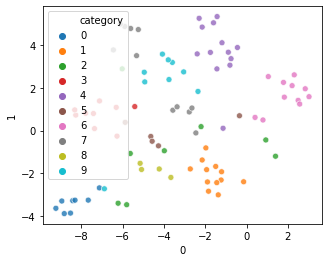

In [186]:
#tsne transformed data
plot_tsne(X_test_transformed, y_test[test_sort_index])

## Questions data

from here: https://github.com/AcademiaSinicaNLPLab/sentiment_dataset/tree/master/data

In [6]:
def read_file2df(path):
    lines=Path(path).read_text().split('\n')
    splitted_lines=[line.split(' ',1) for line in lines]
    df=pd.DataFrame(splitted_lines)
    df.columns=['category', 'text']
    df=df[~pd.isnull(df.category)]
    df=df[~pd.isnull(df.text)]
    df=df.dropna()
    return df

In [7]:
df_train=read_file2df('data/questions/TREC.train.all.txt')
df_test=read_file2df('data/questions/TREC.test.all.txt')
df_train.shape, df_test.shape

((5452, 2), (500, 2))

In [8]:
# make  dev set to train svc classifier on plda
df_train2=df_train.sample(frac=.8, random_state=2)
df_dev=df_train[~df_train.index.isin(df_train2.index)]
df_train2.shape, df_dev.shape

((4362, 2), (1090, 2))

In [9]:
df_test.tail()

,category,text
495,3,Who was the 22nd President of the US ?
496,1,What is the money they use in Zambia ?
497,5,How many feet in a mile ?
498,1,What is the birthstone of October ?
499,0,What is e-coli ?


In [10]:
df_test=df_test.sort_values('category')
df_test=df_test.reset_index(drop=True)
df_test.head()

,category,text
0,0,What is e-coli ?
1,0,What is the Milky Way ?
2,0,Why is the sun yellow ?
3,0,What is an eclipse ?
4,0,What is diabetes ?


#### vectorize

In [11]:
veccer=CountVectorizer()
X=veccer.fit_transform(df_train2['text'].tolist())

In [12]:
X_test=veccer.transform(df_test['text'].tolist())

In [13]:
X_dev=veccer.transform(df_dev['text'].tolist())

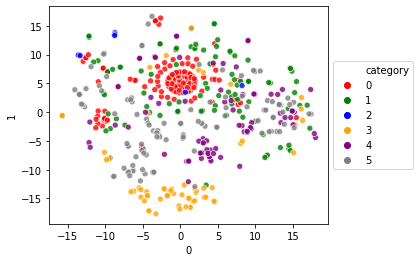

In [14]:
#tsne orig data
plot_tsne(X_test.toarray(), df_test.category, palette=['red','green', 'blue', 'orange', 'purple','grey'])

#### plda

In [15]:
plda_class=plda.Classifier()
plda_class.fit_model(X.toarray(), df_train2.category.tolist(), n_principal_components=3500)

In [16]:
plda_pred, log_p_predictions, X_test_transformed=plda_class.predict(X_test.toarray(), return_data=True)

In [17]:
plda_pred_dev, log_p_predictions_dev, X_dev_transformed =plda_class.predict(X_dev.toarray(), return_data=True)

In [18]:
#raw accuracy
print(classification_report(df_test.category.tolist(), plda_pred))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       138
           1       0.84      0.76      0.79        94
           2       1.00      0.78      0.88         9
           3       0.91      0.89      0.90        65
           4       0.89      0.80      0.84        81
           5       0.98      0.84      0.90       113

    accuracy                           0.86       500
   macro avg       0.89      0.84      0.86       500
weighted avg       0.87      0.86      0.86       500



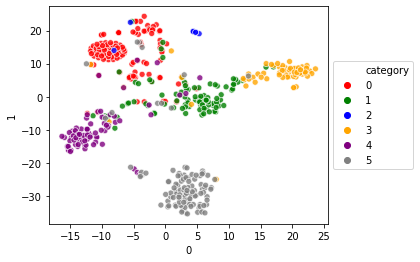

In [19]:
#tsne data plda transformed
plot_tsne(X_test_transformed, df_test.category, palette=['red','green', 'blue', 'orange', 'purple','grey'])

#### plot heatmaps

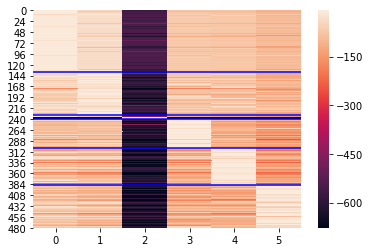

In [26]:
#plda score vecs of different questions combined
new_number_idx=np.where(df_test.category[:-1] != df_test.category.tolist()[1:])[0]
ax=sns.heatmap(log_p_predictions, robust=True)
ax.hlines(new_number_idx, *ax.get_xlim(),color='blue')

In [27]:
new_number_idx

array([137, 231, 240, 305, 386], dtype=int64)

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (500). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


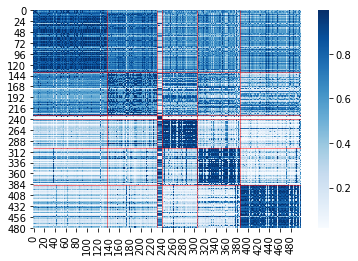

In [56]:
#cosine similarity of different plda score vectors
cossim_mat=cosine_similarity(log_p_predictions, log_p_predictions)
#normalize for better visualization 
scaler=QuantileTransformer()
cossim_mat=scaler.fit_transform(cossim_mat)

ax=sns.heatmap(cossim_mat, robust=True, cmap='Blues')
ax.hlines(new_number_idx, *ax.get_xlim(),color='red', linewidth=0.5)
ax.vlines(new_number_idx, *ax.get_xlim(),color='red', linewidth=0.5)

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (500). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


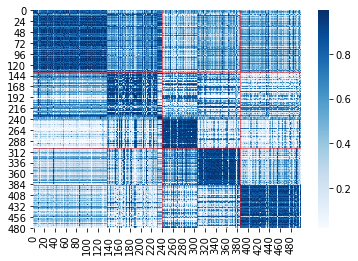

In [69]:
#cosine similairty using transformed features
cossim_mat_transformed=cosine_similarity(X_test_transformed, X_test_transformed)
#normalize for better visualization 
scaler=QuantileTransformer()
cossim_mat_transformed=scaler.fit_transform(cossim_mat_transformed)

ax=sns.heatmap(cossim_mat_transformed, robust=True, cmap='Blues')
ax.hlines(new_number_idx, *ax.get_xlim(),color='red', linewidth=0.5)
ax.vlines(new_number_idx, *ax.get_xlim(),color='red', linewidth=0.5)

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (500). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


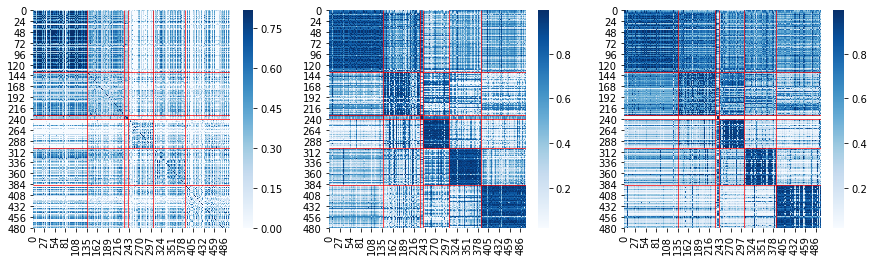

In [72]:
#compare with original data cossim similarity wo PLDA
cossim_mat_orig=cosine_similarity(X_test, X_test)
#normalize for better visualization 
scaler=QuantileTransformer()
cossim_mat=scaler.fit_transform(cossim_mat)

fig, axes =plt.subplots(ncols=3, figsize=(15,4))
ax=sns.heatmap(cossim_mat_orig, ax=axes[0],robust=True, cmap='Blues')
ax.hlines(new_number_idx, *ax.get_xlim(),color='red', linewidth=0.7)
ax.vlines(new_number_idx, *ax.get_xlim(),color='red', linewidth=0.7)

ax=sns.heatmap(cossim_mat_transformed, ax=axes[1], robust=True, cmap='Blues')
ax.hlines(new_number_idx, *ax.get_xlim(),color='red', linewidth=0.7)
ax.vlines(new_number_idx, *ax.get_xlim(),color='red', linewidth=0.7)


ax=sns.heatmap(cossim_mat, ax=axes[2], robust=True, cmap='Blues')
ax.hlines(new_number_idx, *ax.get_xlim(),color='red', linewidth=0.7)
ax.vlines(new_number_idx, *ax.get_xlim(),color='red', linewidth=0.7)

#### svc

In [33]:
svc=LinearSVC()
svc.fit(X.toarray(), df_train2.category.tolist())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [34]:
X_test.toarray().shape, df_test.category.shape

((500, 7348), (500,))

In [35]:
svc_pred=svc.predict(X_test.toarray())

In [36]:
#raw accuracy
print(classification_report(df_test.category.tolist(), svc_pred))

              precision    recall  f1-score   support

           0       0.78      0.99      0.88       138
           1       0.88      0.74      0.80        94
           2       1.00      0.78      0.88         9
           3       0.91      0.91      0.91        65
           4       0.88      0.81      0.85        81
           5       0.99      0.86      0.92       113

    accuracy                           0.87       500
   macro avg       0.91      0.85      0.87       500
weighted avg       0.88      0.87      0.87       500



#### svc on plda results scores

In [37]:
svc_plda=LinearSVC()
svc_plda.fit(log_p_predictions_dev, df_dev.category.tolist())

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [38]:
svc_pred_plda=svc_plda.predict(log_p_predictions)

In [39]:
#raw accuracy
print(classification_report(df_test.category.tolist(), svc_pred_plda))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70       138
           1       1.00      0.12      0.21        94
           2       1.00      0.78      0.88         9
           3       1.00      0.63      0.77        65
           4       0.84      0.81      0.82        81
           5       0.92      0.87      0.89       113

    accuracy                           0.72       500
   macro avg       0.88      0.70      0.71       500
weighted avg       0.83      0.72      0.68       500



#### svc on transformed data

In [40]:
svc_plda=LinearSVC()
svc_plda.fit(X_dev_transformed, df_dev.category.tolist())

C:\Users\risto\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [41]:
svc_pred_plda_trans=svc_plda.predict(X_test_transformed)

In [42]:
print(classification_report(df_test.category.tolist(), svc_pred_plda_trans))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       138
           1       0.82      0.77      0.79        94
           2       1.00      0.78      0.88         9
           3       0.91      0.89      0.90        65
           4       0.88      0.85      0.87        81
           5       1.00      0.87      0.93       113

    accuracy                           0.87       500
   macro avg       0.90      0.85      0.87       500
weighted avg       0.88      0.87      0.87       500



#### combine svc preds

In [43]:
df_svc_preds=pd.DataFrame({'plda_trans':svc_pred_plda_trans,'plda_scores': svc_pred_plda,
                           'svc':svc_pred})

In [44]:
df_preds_combined=df_svc_preds.mode(axis=1)[0]

In [45]:
print(classification_report(df_test.category.tolist(), df_preds_combined))

              precision    recall  f1-score   support

           0       0.75      0.99      0.86       138
           1       0.91      0.72      0.80        94
           2       1.00      0.78      0.88         9
           3       0.95      0.89      0.92        65
           4       0.89      0.84      0.87        81
           5       0.99      0.87      0.92       113

    accuracy                           0.87       500
   macro avg       0.92      0.85      0.87       500
weighted avg       0.89      0.87      0.87       500

